# Gradient Boosted Regression Model
---

In [1]:
# pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# xgboost regressor model
from xgboost import XGBRegressor

# sci-kit learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

/home/alvern/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data Setup

In [2]:
# read in files as dfs
mpls_df = pd.read_csv('resources/mpls_solar_weather.csv')
olg_df = pd.read_csv('resources/olg_solar_weather.csv')

# # randomize rows in df
# mpls_df = mpls_df.sample(frac=1).reset_index(drop=True)
# olg_df = olg_df.sample(frac=1).reset_index(drop=True)

# select features to train on
features = [
    'clouds_all', 'temp_f', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'hour', 'day_of_year',
    'month', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'sin_month', 'cos_month', 'dl_sec'
]

# parameter to predict
target = 'power_delivered'

# get input dimensions
input_dim = len(features)

## XGBoost Regression

In [3]:
def get_features_target(df):
    '''Takes in df and returns features and target dataframes for training and validation.'''
    X = df[features].copy()
    y = df[target].copy()
    
    return X, y

In [4]:
def k_fold_cv(X, y, k):
    '''Performs k-fold cross-validation on data (X) with labels (y). Outputs array of r2 score results.'''
    
    kfold = KFold(n_splits=k, random_state=42)
    results = cross_val_score(xg_reg, X, y, cv=kfold, scoring='r2', verbose=2, n_jobs=-1)
    
    return results

In [5]:
def scale_data_MinMax(X):
    '''Scales and transforms data using sklearn.preprocessing.MinMaxScaler().'''
    
    # fit the scaler
    X_scaler = MinMaxScaler().fit(X)
    # transform data
    X_scaled = X_scaler.transform(X)
    
    return X_scaled

In [6]:
# setup XGBoost Regressor model
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 1000)

## 10-Fold Cross-Validation

In [7]:
# dict of solar datasets to loop over
dfs_dict = {'mpls': mpls_df,
            'olg': olg_df}

# dict to store results
cv_results = {}

# perform cross validation on datasets
for key in dfs_dict:
    # get features and target
    X, y = get_features_target(dfs_dict[key])
    
    # scale data
    X_scaled = scale_data_MinMax(X)
    
    # perform 10-fold cross-validation, store in dict
    cv_results[key] = k_fold_cv(X_scaled, y, 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   15.5s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [8]:
# print results for each solar setup
for key in dfs_dict:
    print(f"Results for {key} solar setup:")
    print(f"  Model: XGBoost Regressor - Max Depth: {xg_reg.max_depth}, estimators: {xg_reg.n_estimators}")
    print()
    print("10-fold cross-validation:\n  r2 score: %.2f (%.2f)" % \
          (cv_results[key].mean(), cv_results[key].std()))
    print("-------------------------------------\n\n")

Results for mpls solar setup:
  Model: XGBoost Regressor - Max Depth: 5, estimators: 1000

10-fold cross-validation:
  r2 score: 0.77 (0.18)
-------------------------------------


Results for olg solar setup:
  Model: XGBoost Regressor - Max Depth: 5, estimators: 1000

10-fold cross-validation:
  r2 score: 0.84 (0.06)
-------------------------------------




## Model Training

### Mpls Solar Panel

#### Train

In [9]:
# mpls data:
X, y = get_features_target(mpls_df)   # get data
X_scaled = scale_data_MinMax(X)   # scale data
xg_reg.fit(X_scaled, y)     # train model

# save model
joblib.dump(xg_reg, 'mpls_xg_reg_nosampling.dat')
print('Saved model to "mpls_xg_reg.dat"')

Saved model to "mpls_xg_reg.dat"


#### Plot Feature Importances

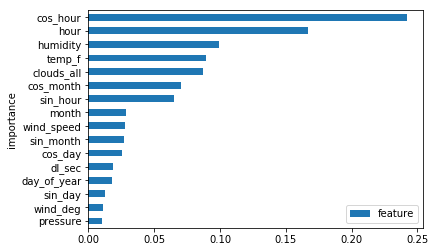

In [10]:
features_df = pd.DataFrame(features, xg_reg.feature_importances_).reset_index()

features_df.columns = ['feature', 'importance']

features_df = features_df.sort_values('feature', ascending=True).reset_index()

plot_mpls = features_df.plot('importance', 'feature', kind='barh')

### Ogilvie Solar Panel

#### Train Model

In [11]:
# # olg data:
# X, y = get_features_target(olg_df)   # get data
# X_scaled = scale_data_MinMax(X)   # scale data
# xg_reg.fit(X_scaled, y)     # train model

# # save model
# joblib.dump(xg_reg, 'olg_xg_reg.joblib.dat')
# print('Saved model to "olg_xg_reg.joblib.dat"')

#### Plot Feature Importances

In [12]:
# features_df = pd.DataFrame(features, xg_reg.feature_importances_).reset_index()

# features_df.columns = ['feature', 'importance']

# features_df = features_df.sort_values('feature', ascending=True).reset_index()

# plot_olg = features_df.plot('importance', 'feature', kind='barh')